# Time-strain inversion of the Hess 4D modeled post-stack seismic data 

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pylops.avo.poststack import PoststackLinearModelling
from strainprox.utils import *
from strainprox.functions import *
from pylops import CausalIntegration
from scipy.interpolate import interp1d
from pylops.basicoperators import Gradient, Diagonal
from pyproximal import L21, L2
import warnings
from matplotlib.colors import ListedColormap, BoundaryNorm
warnings.filterwarnings("ignore")
import os
os.chdir('/ibex/user/romerojd/strainprox')

## Data loading

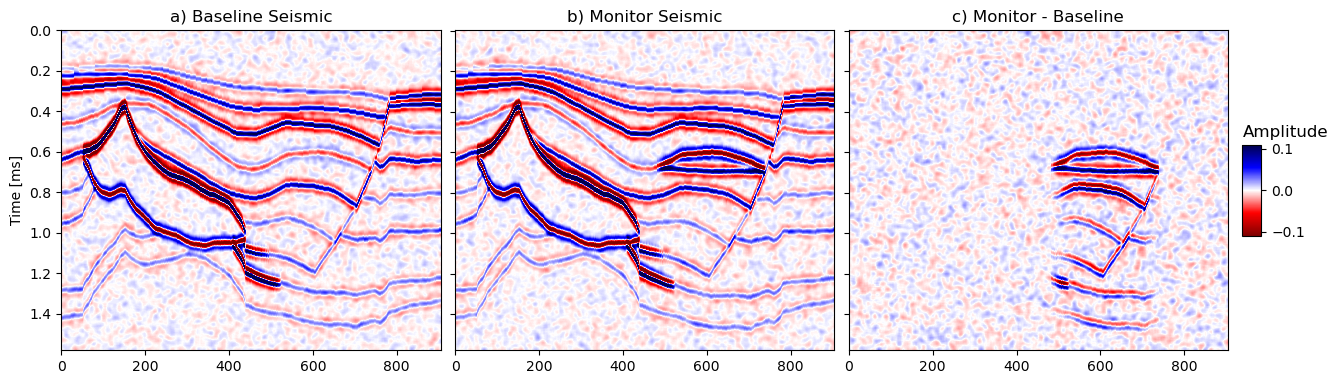

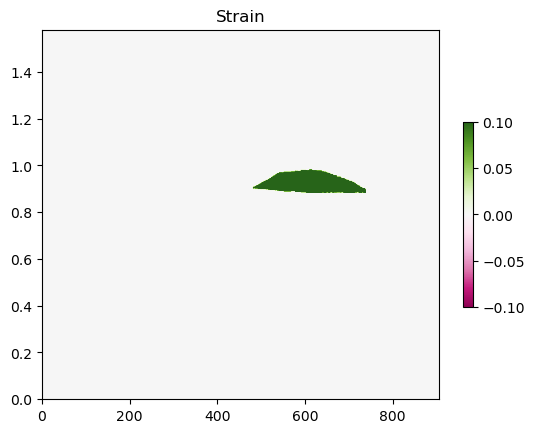

In [2]:
dtype = 'float64'
hess = np.load('./data/Hess/Hess4d_time.npz')
wav = hess['wav'].astype(np.float32)
d1 = hess['dn1'].astype(np.float32)
d2 = hess['dn2'].astype(np.float32)
utrue = hess['straint'].astype(np.float32)
dims = utrue.shape
dt = 0.004
t = np.arange(dims[0], dtype=dtype)*dt

plotter_4D(d1, d2, dt=dt, ztitle='Time [ms]', type='seismic')
plt.show()
plt.imshow(utrue, cmap='PiYG', vmin=-0.1, vmax=0.1, extent=(0, dims[1], 0, dims[0]*dt))
plt.title('Strain')
plt.axis('tight')
plt.colorbar(shrink=0.5)
plt.show()

## Time-strain inversion

$$
     \Delta u = \argmin_{\Delta u}\Vert d_1(t) - d_2(t+ dt C  u_{i-1}) - dt  J_{d_2} C \Delta u \Vert^2  + \Vert \nabla (\Delta u + u_{i-1})\Vert_{1}
$$

Total time 235.430860


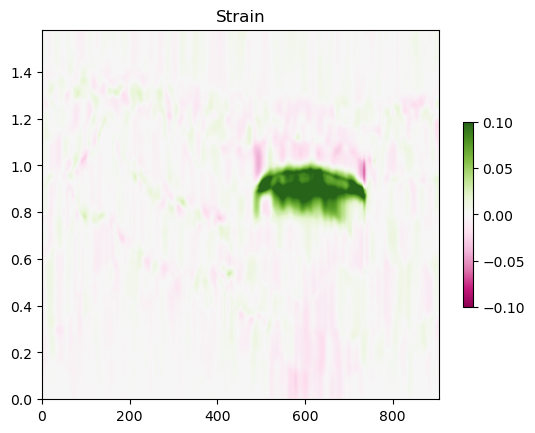

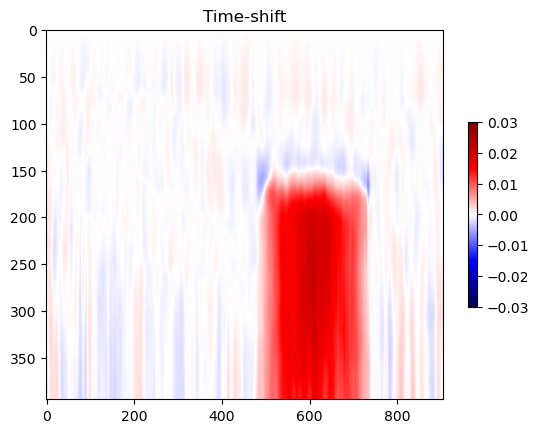

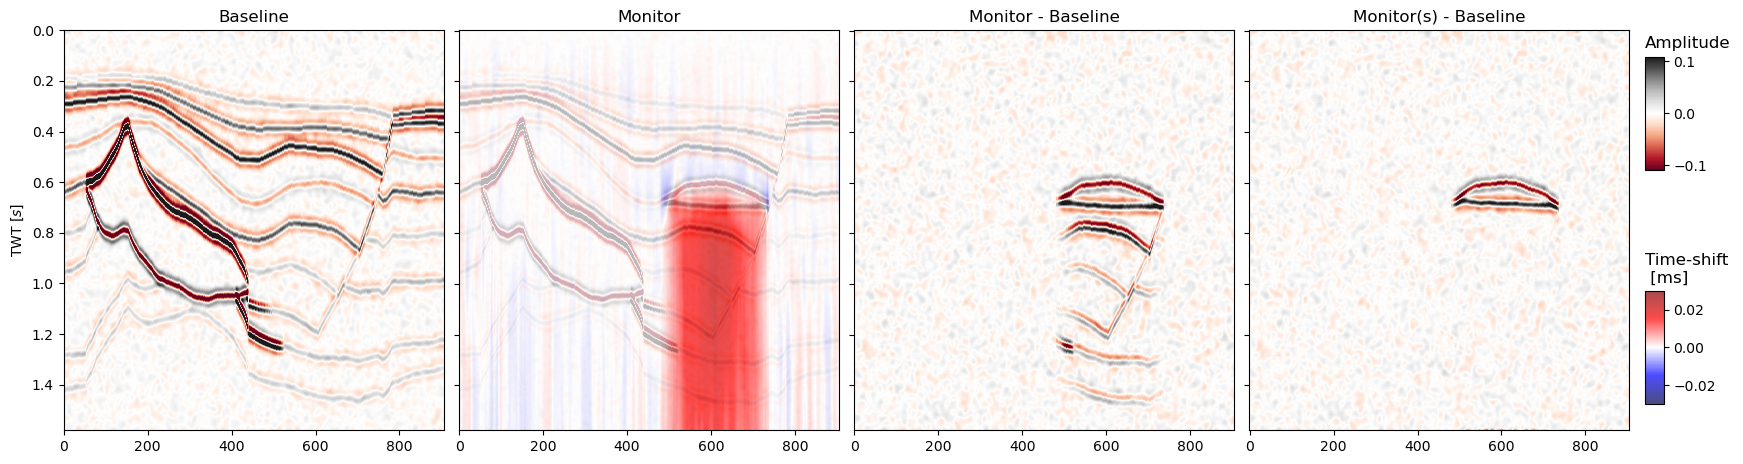

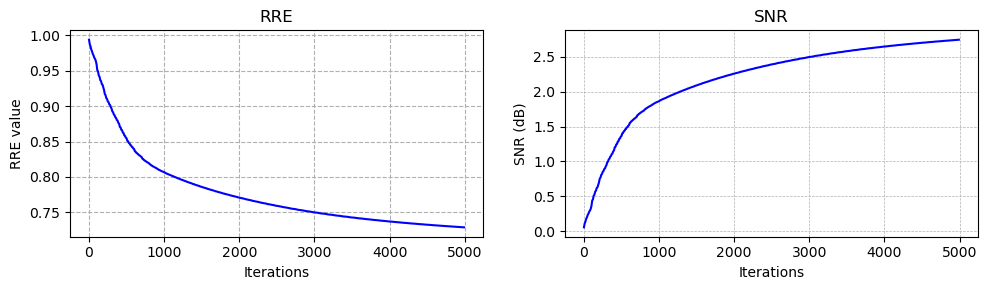

In [3]:
sigma = 1.
l2niter = 10
pdniter = 10
outeriter = 50

# Linear Operators
Dop = Gradient(dims=dims, edge=True, dtype=dtype, kind='forward')
l1 = L21(ndim=len(dims), sigma=sigma)
C = CausalIntegration(dims=dims, axis=0, sampling=dt, dtype=dtype)
D = FirstDerivative(dims=dims, axis=0, sampling=dt, dtype=dtype)

# Variables
ui = np.zeros(np.prod(dims)) # strain at iteration i
d2i = d2.copy() # Shifted monitor data at iteration i

L = 8.  # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0]) = 7.99
mu = .1
tau = .99 / (mu * L)

xhist, xsnr, xerr = [], [], []
start_time = time.perf_counter()
for i in range(outeriter):
    d = d1.ravel() - d2i.ravel()  
    J = Diagonal(D*d2i, dtype=dtype)
    Op = J * C
    l2 = L2(Op=Op, b=d, niter=l2niter, warm=True, x0=np.zeros(np.prod(dims)))
    b = Dop * ui
    ui += PrimalDual2(l2, l1, Dop, b, tau=tau, mu=mu, theta=1., x0=np.zeros(np.prod(dims)), niter=pdniter,
                    callback=lambda xx:callbackx(xx.copy(), ui.copy(), utrue.ravel(), xhist, xsnr, xerr), 
                    show=False)
    
    interpolators = [
    interp1d((t.copy()[:, np.newaxis] - (C*ui).reshape(dims))[:,col], d2[:, col], kind='cubic', fill_value="extrapolate")
    for col in range(d2.shape[1])]
    for col, interpolator in enumerate(interpolators):
        d2i[:, col] = interpolator(t)


total_time = time.perf_counter() - start_time
print('Total time %f' % total_time)
plt.imshow(ui.reshape(dims), cmap='PiYG', vmin=-0.1, vmax=0.1, extent=(0, dims[1], 0, dims[0]*dt))
plt.title('Strain')
plt.axis('tight')
plt.colorbar(shrink=0.5)
plt.show()
plt.imshow((C*ui).reshape(dims), cmap='seismic', vmin=-0.03, vmax=0.03)
plt.title('Time-shift')
plt.axis('tight')
plt.colorbar(shrink=0.5)
plt.show()
plotter_timeshift(d1, d2, d2i, shift=(C*ui).reshape(dims), dt=dt)
plt.show()    
fig, ax = plt.subplots(1, 2, figsize=(10, 3))  # Increased height slightly for better visibility
ax[0].plot( np.arange(len(xerr))*l2niter,xerr, color='blue', linestyle='-', linewidth=1.5)
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('RRE value')
ax[0].set_title('RRE')
ax[0].grid(True, linestyle='--')
ax[1].plot(np.arange(len(xerr))*l2niter, xsnr, color='blue', linestyle='-', linewidth=1.5)
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('SNR (dB)')
ax[1].set_title('SNR')
ax[1].grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.subplots_adjust(wspace=0.2) 
plt.show()

## Time-strain inversion with data term

$$
     \Delta u = \argmin_{\Delta u}\Vert d_1(t) - d_2(t+ dt C  u_{i-1}) - G(u_{i-1}) -  (G + dt  J_{d_2} C) \Delta u \Vert^2  + \Vert \nabla (\Delta u + u_{i-1})\Vert_{1}
$$

Total time 419.179603


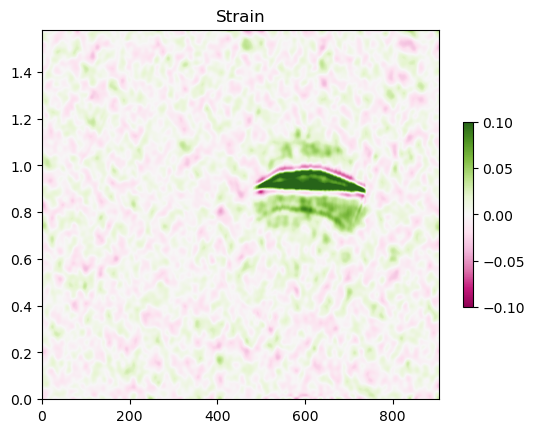

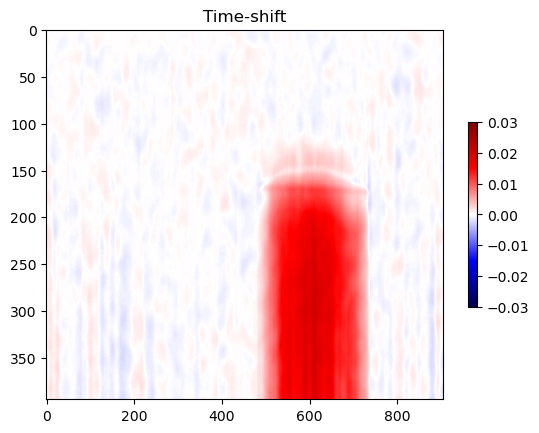

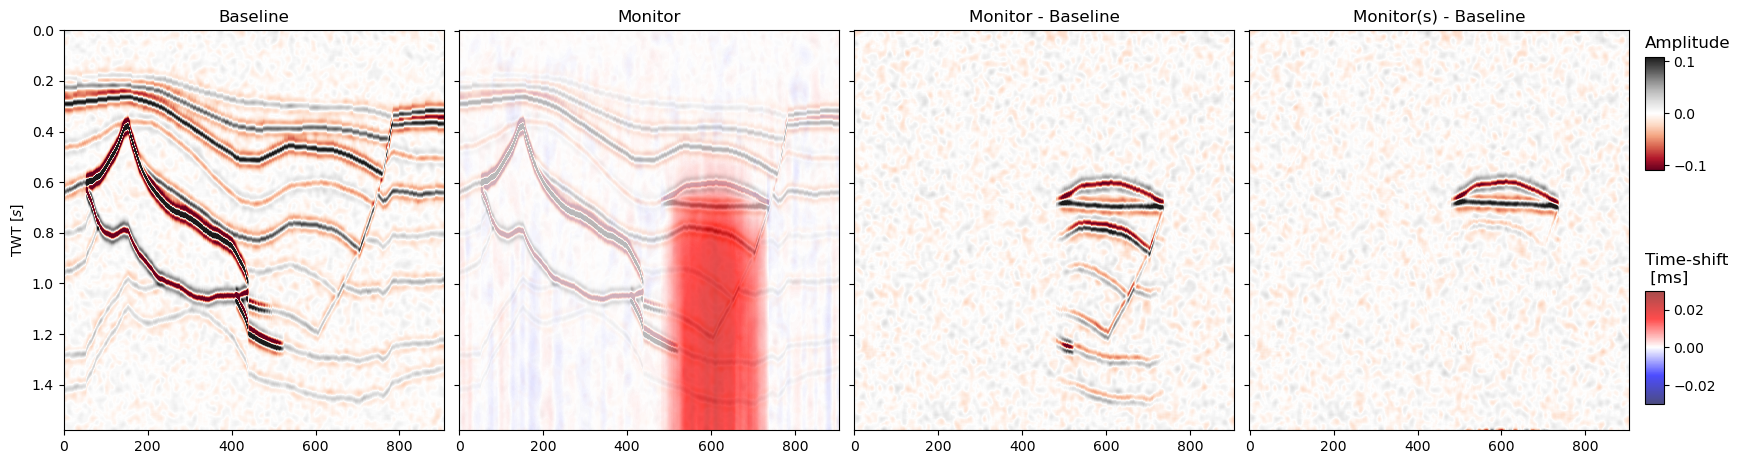

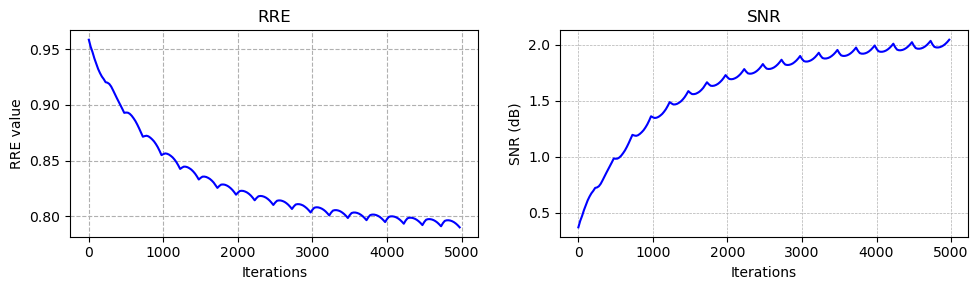

In [4]:
sigma = 1.
l2niter = 25
pdniter = 10
outeriter = 20

# Linear Operators
G = PoststackLinearModelling(wav/2, nt0=dims[0], spatdims=dims[1:])
Dop = Gradient(dims=dims, edge=True, dtype=dtype, kind='forward')
l1 = L21(ndim=len(dims), sigma=sigma)
C = CausalIntegration(dims=dims, axis=0, sampling=dt, dtype=dtype)
D = FirstDerivative(dims=dims, axis=0, sampling=dt, dtype=dtype)

# Variables
ui = np.zeros(np.prod(dims)) # strain at iteration i
d2i = d2.copy() # Shifted monitor data at iteration i

L = 8.  # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0]) = 7.99
mu = .1
tau = .99 / (mu * L)

xhist, xsnr, xerr = [], [], []
start_time = time.perf_counter()
for i in range(outeriter):
    d = d1.ravel() - d2i.ravel() - (G*ui)
    J = Diagonal(D*d2i, dtype=dtype)
    Op = G + J * C
    l2 = L2(Op=Op, b=d, niter=l2niter, warm=True, x0=np.zeros(np.prod(dims)))
    b = Dop * ui
    ui += PrimalDual2(l2, l1, Dop, b, tau=tau, mu=mu, theta=1., x0=np.zeros(np.prod(dims)), niter=pdniter,
                    callback=lambda xx:callbackx(xx.copy(), ui.copy(), utrue.ravel(), xhist, xsnr, xerr), 
                    show=False)
    
    interpolators = [
    interp1d((t.copy()[:, np.newaxis] - (C*ui).reshape(dims))[:,col], d2[:, col], kind='cubic', fill_value="extrapolate")
    for col in range(d2.shape[1])]
    for col, interpolator in enumerate(interpolators):
        d2i[:, col] = interpolator(t)


total_time = time.perf_counter() - start_time
print('Total time %f' % total_time)
plt.imshow(ui.reshape(dims), cmap='PiYG', vmin=-0.1, vmax=0.1, extent=(0, dims[1], 0, dims[0]*dt))
plt.title('Strain')
plt.axis('tight')
plt.colorbar(shrink=0.5)
plt.show()
plt.imshow((C*ui).reshape(dims), cmap='seismic', vmin=-0.03, vmax=0.03)
plt.title('Time-shift')
plt.axis('tight')
plt.colorbar(shrink=0.5)
plt.show()
plotter_timeshift(d1, d2, d2i, shift=(C*ui).reshape(dims), dt=dt)
plt.show()    
fig, ax = plt.subplots(1, 2, figsize=(10, 3))  # Increased height slightly for better visibility
ax[0].plot( np.arange(len(xerr))*l2niter,xerr, color='blue', linestyle='-', linewidth=1.5)
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('RRE value')
ax[0].set_title('RRE')
ax[0].grid(True, linestyle='--')
ax[1].plot(np.arange(len(xerr))*l2niter, xsnr, color='blue', linestyle='-', linewidth=1.5)
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('SNR (dB)')
ax[1].set_title('SNR')
ax[1].grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.subplots_adjust(wspace=0.2) 
plt.show()

## Joint-inversion and segmentation

Working with alpha=10.000000,  beta=10.000000,  delta=2.000000
Iteration 0...
f= 5.107978315573004
||v-v_old||_2= 410.3279786749455
||m-m_old||_2= 6.4551093760946285
RRE= 0.9204208201936519
PSNR= 0.7202713726007444
Iteration 1...
f= 6.890815454887133
||v-v_old||_2= 17.63471221637865
||m-m_old||_2= 2.4373729132498165
RRE= 0.9004821625307405
PSNR= 0.9104977643891385
Working with alpha=10.000000,  beta=10.000000,  delta=2.000000
Iteration 0...
f= 32.377211629080016
||v-v_old||_2= 410.38831145848417
||m-m_old||_2= 3.207569958541723
RRE= 0.8720419243830027
PSNR= 1.1892527597005111
Iteration 1...
f= 22.563860779052906
||v-v_old||_2= 20.830748657557052
||m-m_old||_2= 2.6524138875532723
RRE= 0.8512304436609401
PSNR= 1.3990571028337913
Working with alpha=10.000000,  beta=10.000000,  delta=2.000000
Iteration 0...
f= 14.613140426096237
||v-v_old||_2= 410.3597684195916
||m-m_old||_2= 2.675514912832258
RRE= 0.8385008197238019
PSNR= 1.5299302219431006
Iteration 1...
f= 16.635734296787337
||v-v_old||

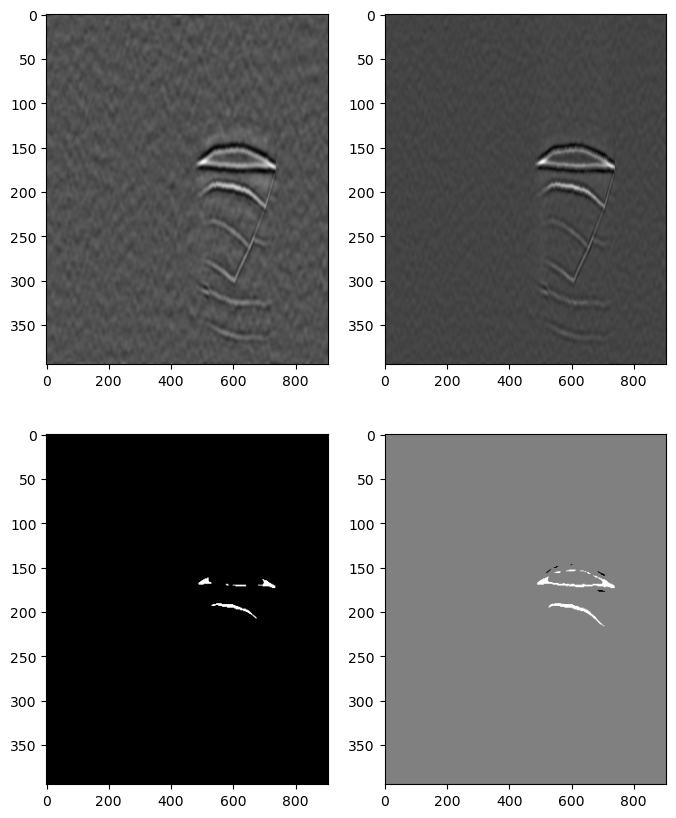

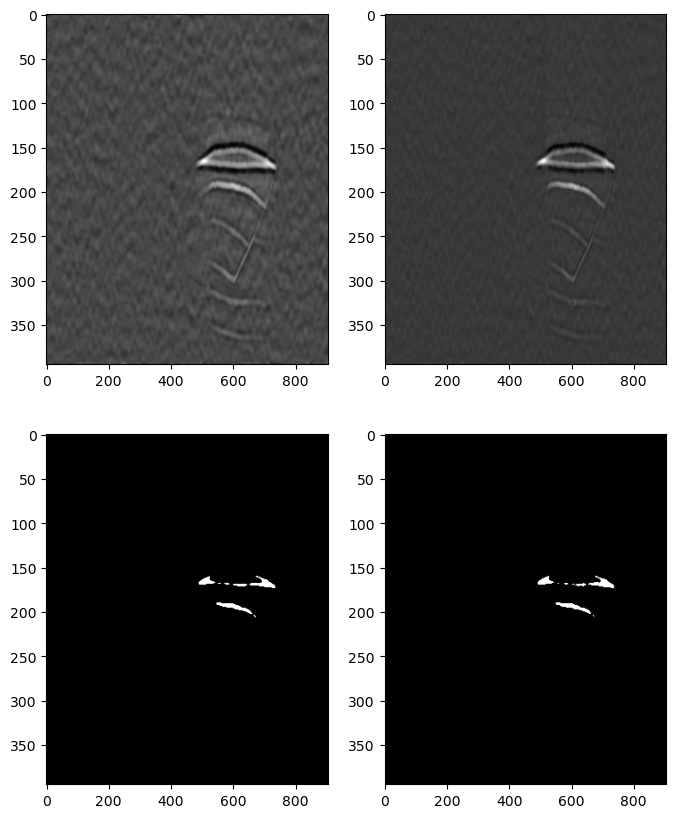

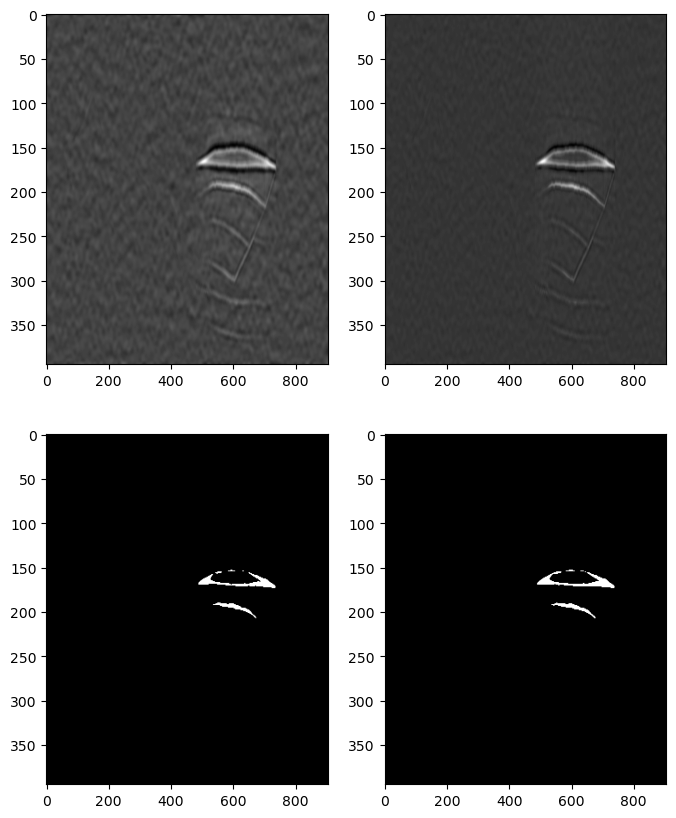

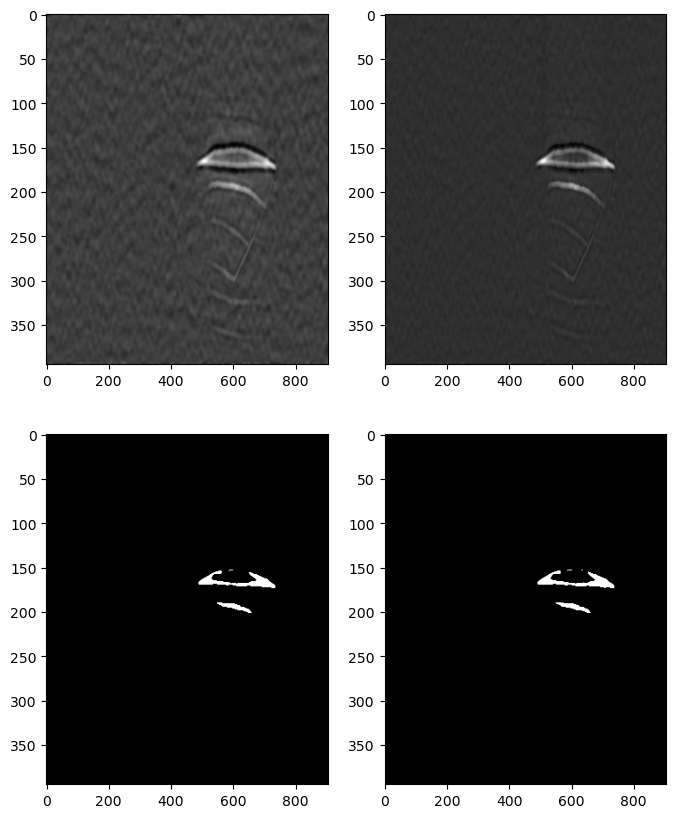

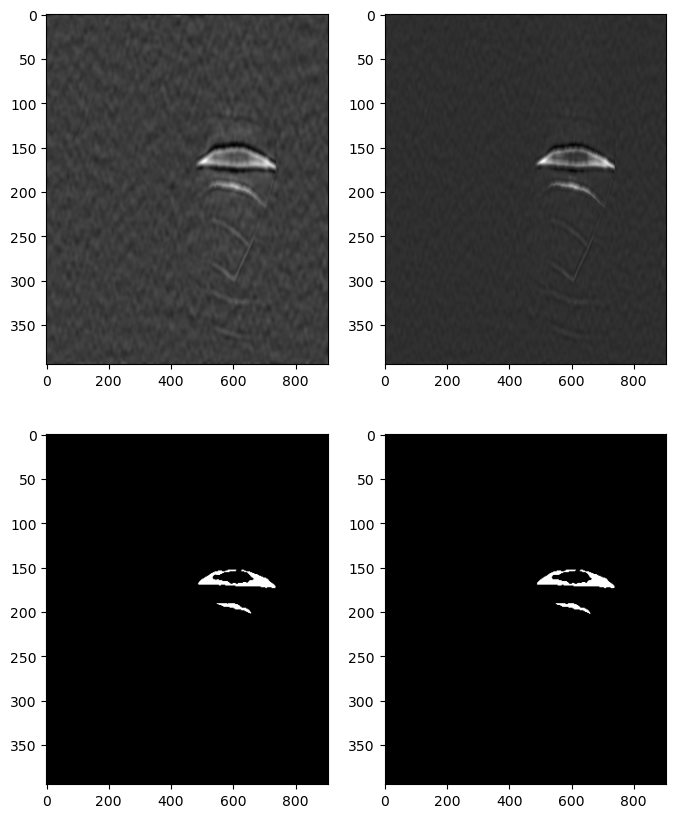

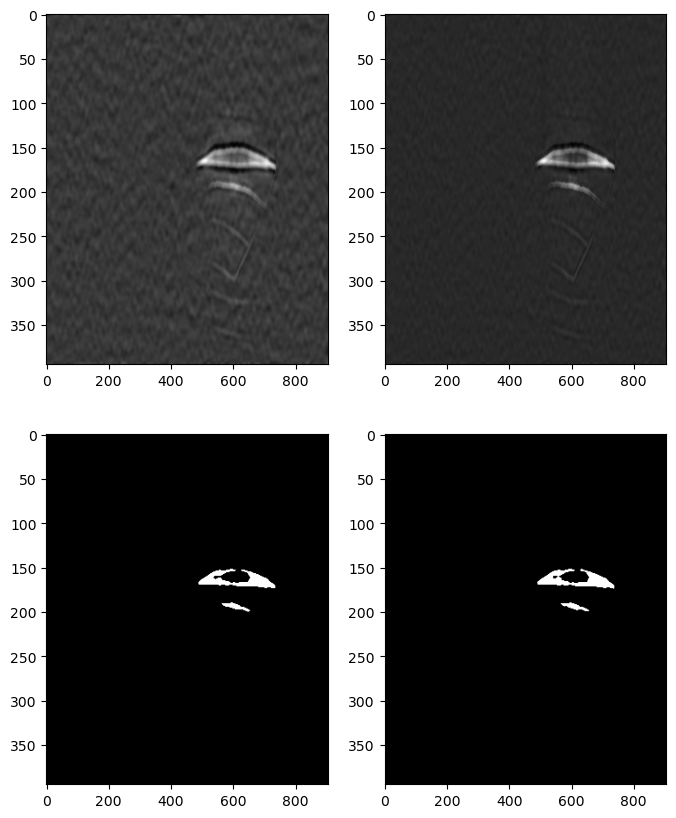

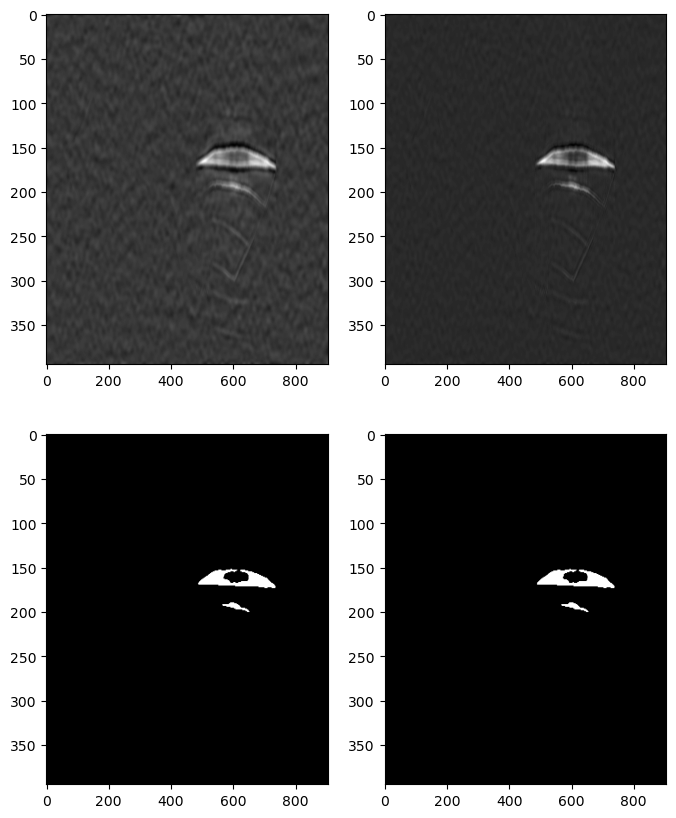

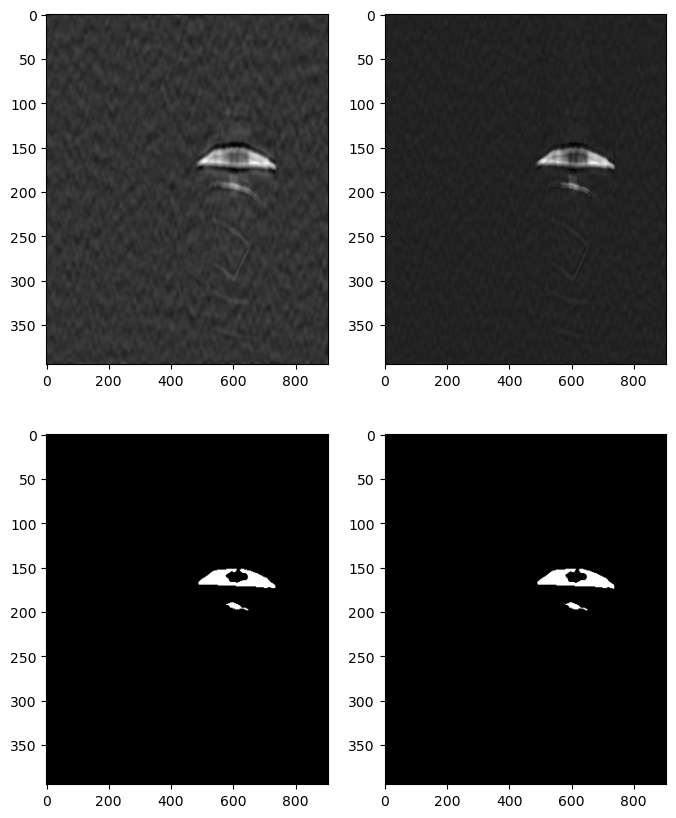

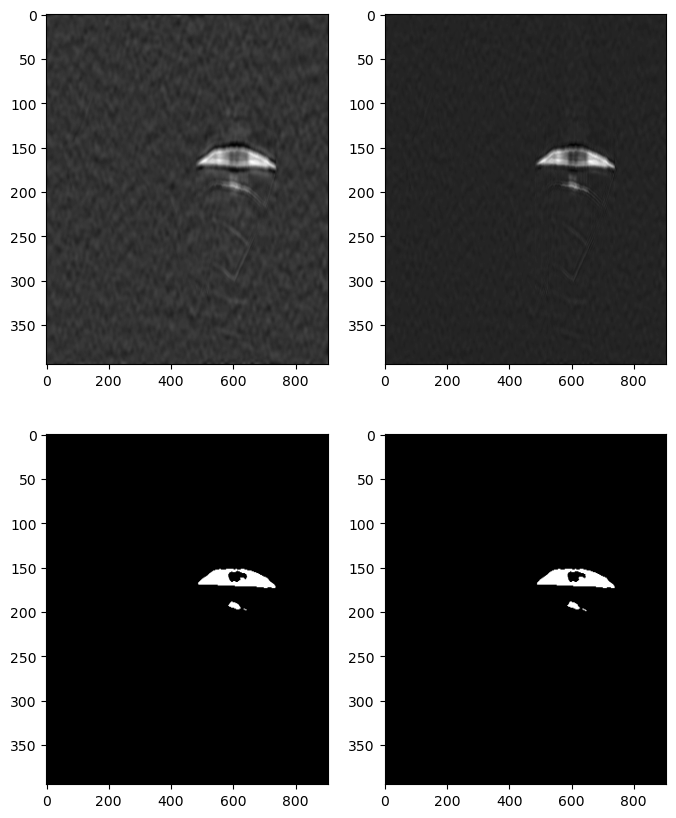

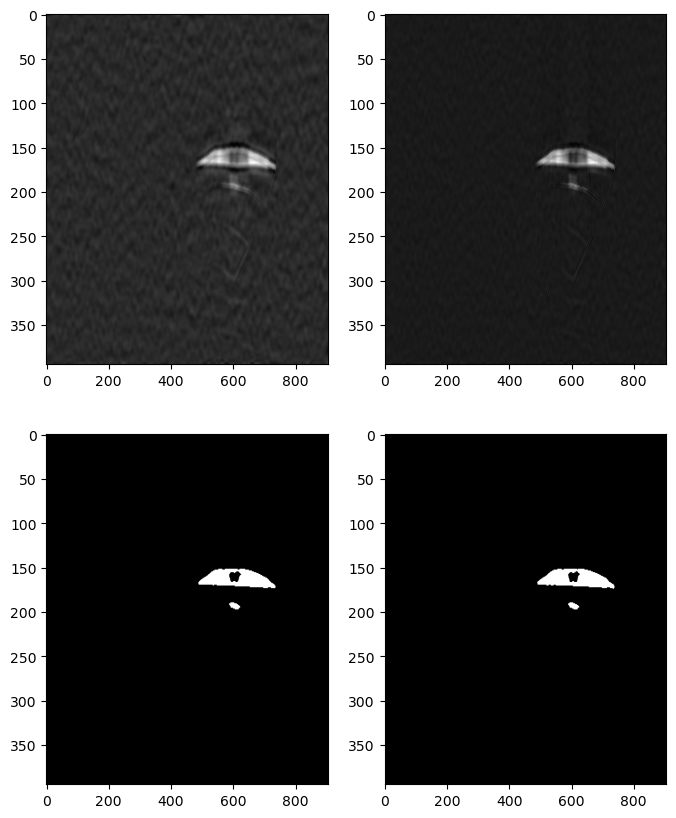

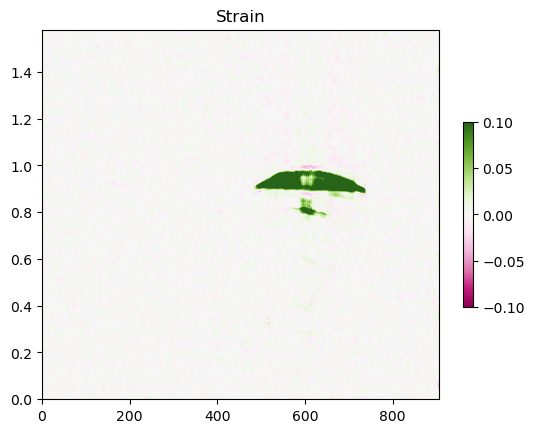

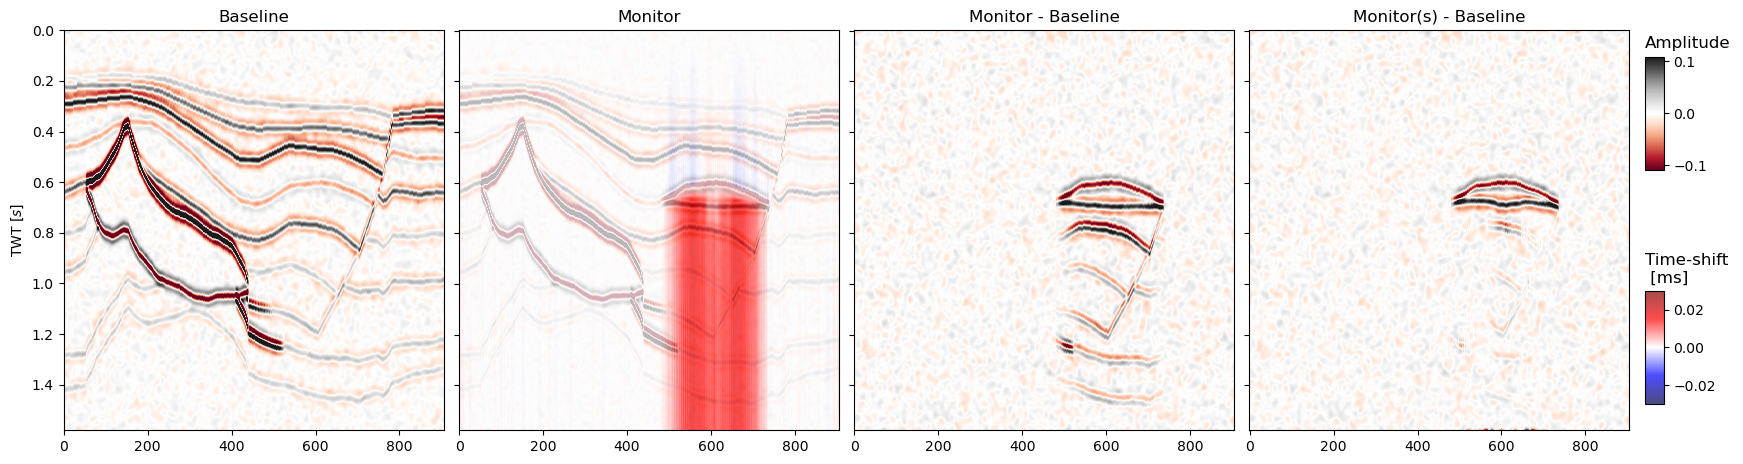

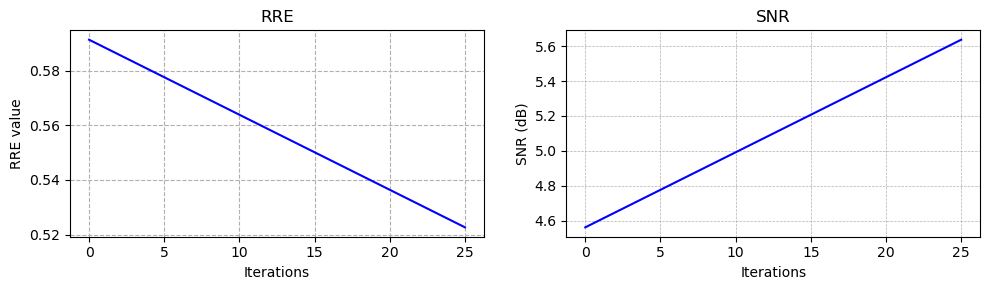

In [5]:
outeriter = 10
niter = 2
l2niter = 25
pdniter = 10
segmentniter=10
bisectniter=10
sigma=1.

# Linear Operators
G = PoststackLinearModelling(wav/2, nt0=dims[0], spatdims=dims[1:])
Dop = Gradient(dims=dims, edge=True, dtype=dtype, kind='forward')
l1 = L21(ndim=len(dims), sigma=sigma)
C = CausalIntegration(dims=dims, axis=0, sampling=dt, dtype=dtype)
D = FirstDerivative(dims=dims, axis=0, sampling=dt, dtype=dtype)

# Variables
ui = np.zeros(np.prod(dims)) # strain at iteration i
d2i = d2.copy() # Shifted monitor data at iteration i

cl = np.array([-0.15, 0, 0.15])
alpha = 10.
beta = 10.
delta = 2.

L = 8.  # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0]) = 7.99
mu = .1
tau = .99 / (mu * L)

start_time = time.perf_counter()
for i in range(outeriter):
    d = d1.ravel() - d2i.ravel()  - (G*ui)
    J = Diagonal(D*d2i, dtype='float32')
    Op = G + J * C
    ui, vcl, xerr, xsnr = \
        strain_jis(d=d, Op=Op, x0=np.zeros(np.prod(dims)), ui=ui, dims=dims, cl=cl, 
                   alpha=alpha, beta=beta, delta=delta, tau=tau, mu=mu,
                   niter=niter , l2niter=l2niter, pdniter=pdniter,
                   segmentniter=segmentniter, bisectniter=bisectniter, bregman=False,
                   utrue=utrue, plotflag=True, show=False)
    
    interpolators = [
    interp1d((t.copy()[:, np.newaxis] - (C*ui).reshape(dims))[:,col], d2[:, col], kind='cubic', fill_value="extrapolate")
    for col in range(d2.shape[1])]
    for col, interpolator in enumerate(interpolators):
        d2i[:, col] = interpolator(t)
    
total_time = time.perf_counter() - start_time
print('Total time (JIS): %.2f s' % total_time)   
plt.show()
plt.imshow(ui.reshape(dims), cmap='PiYG', vmin=-0.1, vmax=0.1, extent=(0, dims[1], 0, dims[0]*dt))
plt.title('Strain')
plt.axis('tight')
plt.colorbar(shrink=0.5)
plt.show()
plotter_timeshift(d1, d2, d2i, shift=(C*ui).reshape(dims), dt=dt)
plt.show()    
fig, ax = plt.subplots(1, 2, figsize=(10, 3))  # Increased height slightly for better visibility
ax[0].plot( np.arange(len(xerr))*l2niter,xerr, color='blue', linestyle='-', linewidth=1.5)
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('RRE value')
ax[0].set_title('RRE')
ax[0].grid(True, linestyle='--')
ax[1].plot(np.arange(len(xerr))*l2niter, xsnr, color='blue', linestyle='-', linewidth=1.5)
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('SNR (dB)')
ax[1].set_title('SNR')
ax[1].grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.subplots_adjust(wspace=0.2) 
plt.show()

### Joint-inversion-segmentation with TV inversion as precursor

Total time (TV-inversion) 207.92 s
Working with alpha=10.000000,  beta=10.000000,  delta=2.000000
Iteration 0...
f= 32.46863074721151
||v-v_old||_2= 412.2876584952918
||m-m_old||_2= 0.28639673186997366
RRE= 0.8066744201745197
PSNR= 1.866034340439259
Iteration 1...
f= 27.207415365435576
||v-v_old||_2= 35.04703895400768
||m-m_old||_2= 4.417494657701592
RRE= 0.6796237096177409
PSNR= 3.354629623612266
Working with alpha=10.000000,  beta=10.000000,  delta=2.000000
Iteration 0...
f= 27.057984181786196
||v-v_old||_2= 410.6343540124804
||m-m_old||_2= 2.4627785341663895
RRE= 0.6929442193466809
PSNR= 3.186034528908859
Iteration 1...
f= 27.40006432704366
||v-v_old||_2= 22.56888871907078
||m-m_old||_2= 3.0171084922274076
RRE= 0.586358787721655
PSNR= 4.636731286564398
Working with alpha=10.000000,  beta=10.000000,  delta=2.000000
Iteration 0...
f= 31.858341501869507
||v-v_old||_2= 410.4111279072908
||m-m_old||_2= 2.2292962721139777
RRE= 0.6185471164296055
PSNR= 4.172544319641816
Iteration 1...
f= 3

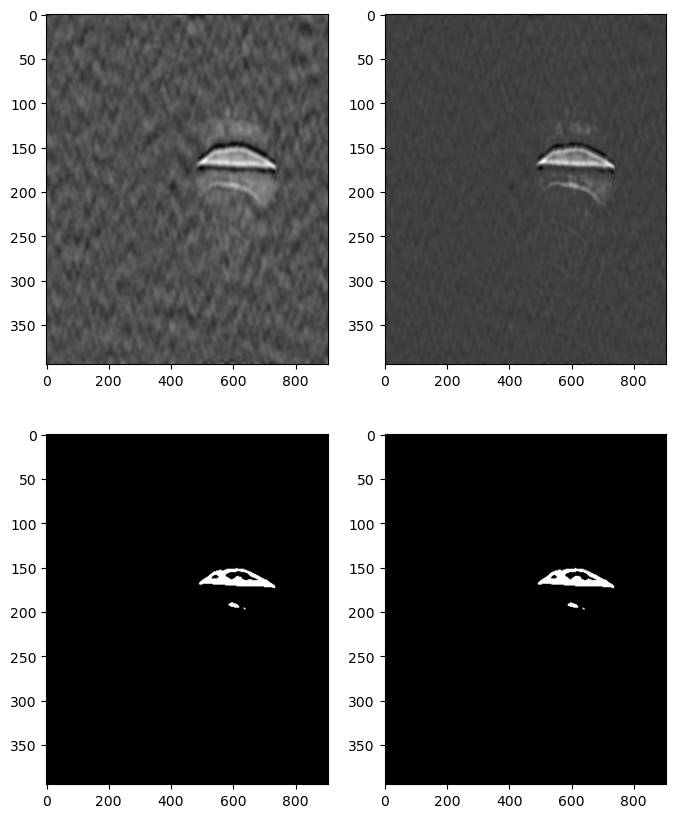

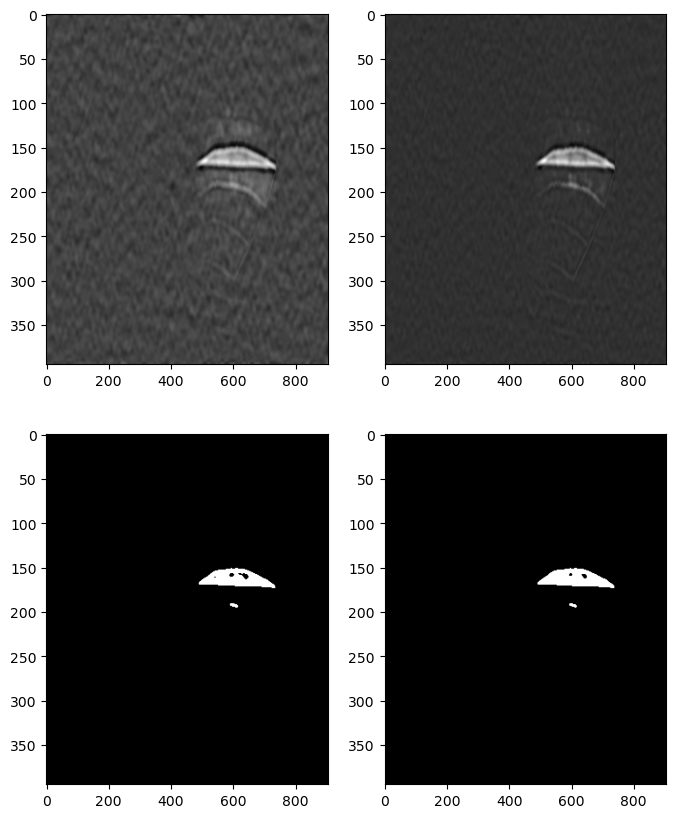

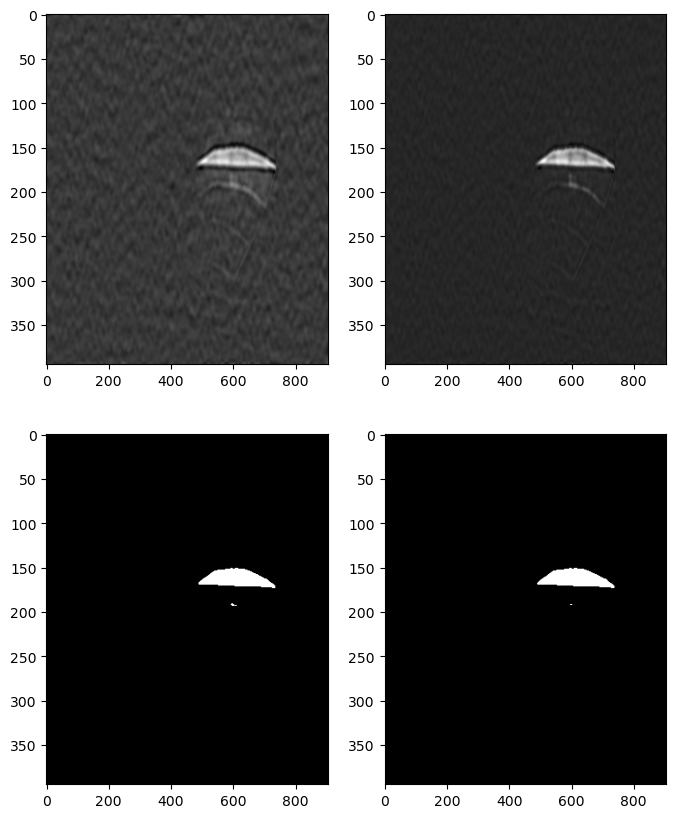

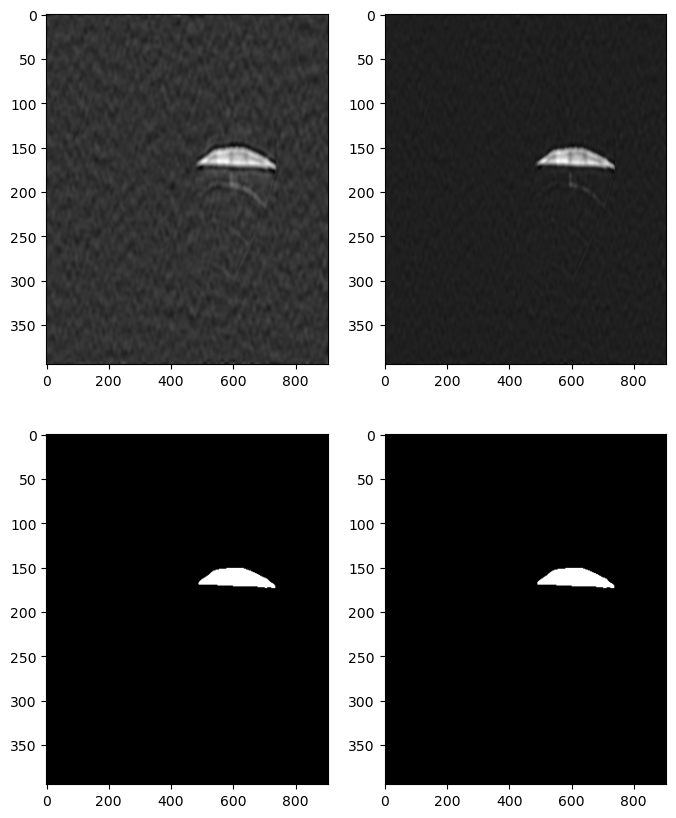

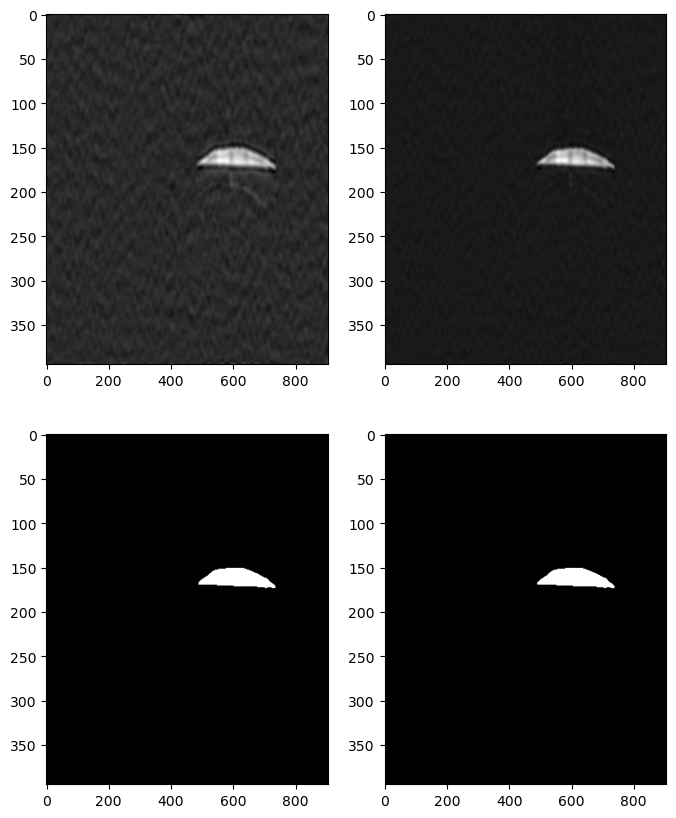

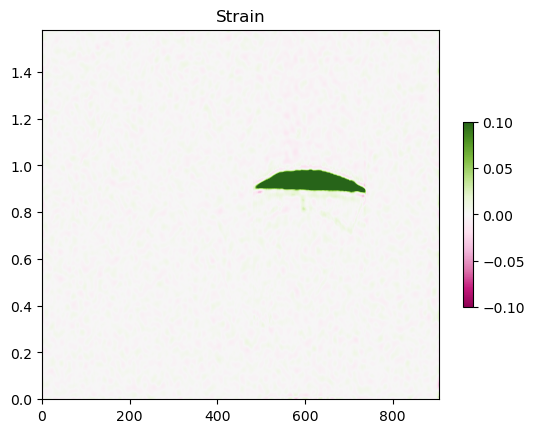

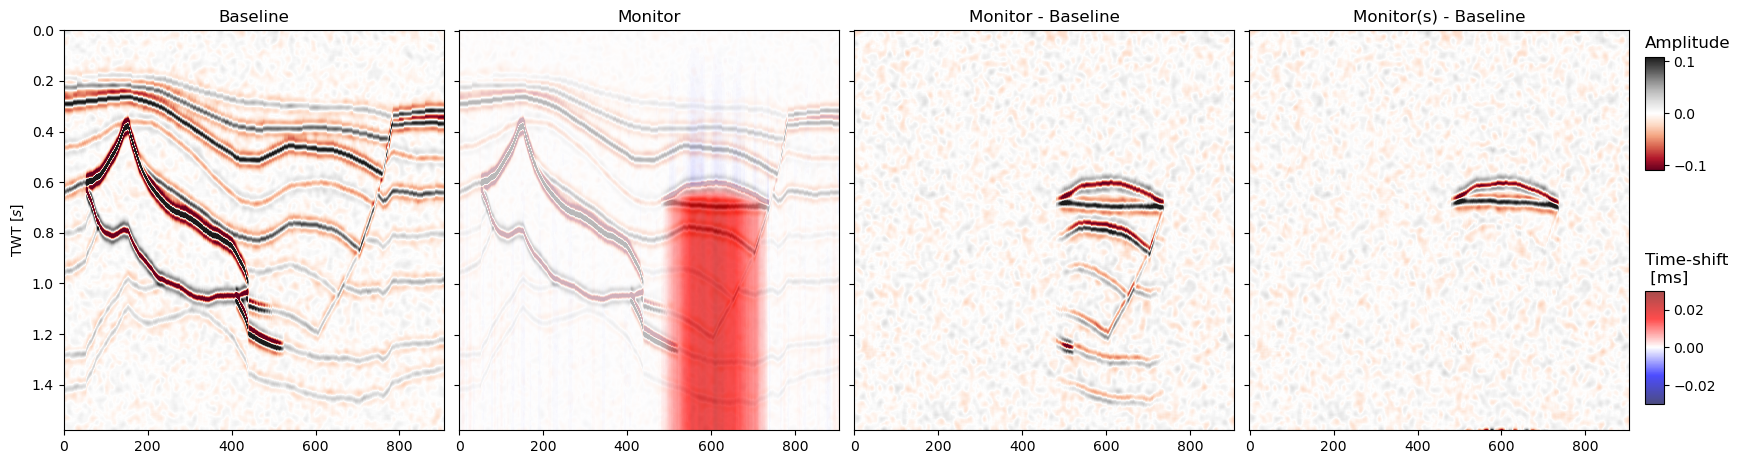

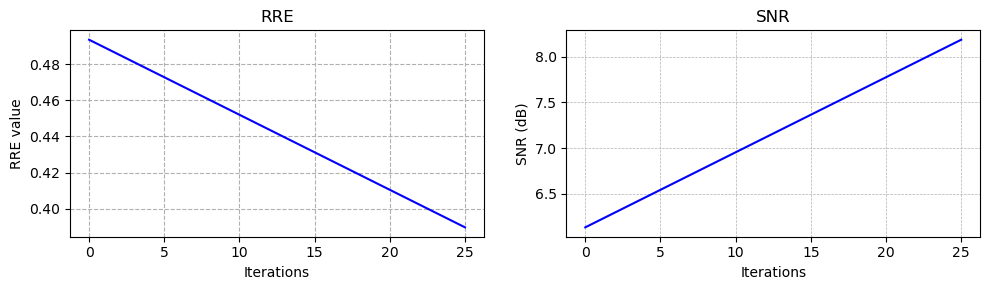

In [6]:
# First part: 10 iterations of pure TV inversion
sigma = 1.
l2niter = 25
pdniter = 10
outeriter = 10

# Linear Operators
G = PoststackLinearModelling(wav/2, nt0=dims[0], spatdims=dims[1:])
Dop = Gradient(dims=dims, edge=True, dtype=dtype, kind='forward')
l1 = L21(ndim=len(dims), sigma=sigma)
C = CausalIntegration(dims=dims, axis=0, sampling=dt, dtype=dtype)
D = FirstDerivative(dims=dims, axis=0, sampling=dt, dtype=dtype)

# Variables
ui = np.zeros(np.prod(dims)) # strain at iteration i
d2i = d2.copy() # Shifted monitor data at iteration i

L = 8.  # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0]) = 7.99
mu = .1
tau = .99 / (mu * L)

xhist, xsnr, xerr = [], [], []
start_time = time.perf_counter()
for i in range(outeriter):
    d = d1.ravel() - d2i.ravel() - (G*ui)
    J = Diagonal(D*d2i, dtype=dtype)
    Op = G + J * C
    l2 = L2(Op=Op, b=d, niter=l2niter, warm=True, x0=np.zeros(np.prod(dims)))
    b = Dop * ui
    ui += PrimalDual2(l2, l1, Dop, b, tau=tau, mu=mu, theta=1., x0=np.zeros(np.prod(dims)), niter=pdniter,
                    callback=lambda xx:callbackx(xx.copy(), ui.copy(), utrue.ravel(), xhist, xsnr, xerr), 
                    show=False)
    
    interpolators = [
    interp1d((t.copy()[:, np.newaxis] - (C*ui).reshape(dims))[:,col], d2[:, col], kind='cubic', fill_value="extrapolate")
    for col in range(d2.shape[1])]
    for col, interpolator in enumerate(interpolators):
        d2i[:, col] = interpolator(t)
total_time = time.perf_counter() - start_time        
print('Total time (TV-inversion) %.2f s' % total_time)  

# Second part: 5 iterations of joint-inversion-segmentation
outeriter = 5
niter = 2
l2niter = 25
pdniter = 10
segmentniter=10
bisectniter=10

cl = np.array([-0.15, 0, 0.15])
alpha = 10.
beta = 10.
delta = 2.

L = 8.  # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0]) = 7.99
mu = .1
tau = .99 / (mu * L)

start_time = time.perf_counter()
for i in range(outeriter):
    d = d1.ravel() - d2i.ravel()  - (G*ui)
    J = Diagonal(D*d2i, dtype='float32')
    Op = G + J * C
    ui, vcl, xerr, xsnr = \
        strain_jis(d=d, Op=Op, x0=np.zeros(np.prod(dims)), ui=ui, dims=dims, cl=cl, 
                   alpha=alpha, beta=beta, delta=delta, tau=tau, mu=mu,
                   niter=niter , l2niter=l2niter, pdniter=pdniter,
                   segmentniter=segmentniter, bisectniter=bisectniter, bregman=False,
                   utrue=utrue, plotflag=True, show=False)
    
    interpolators = [
    interp1d((t.copy()[:, np.newaxis] - (C*ui).reshape(dims))[:,col], d2[:, col], kind='cubic', fill_value="extrapolate")
    for col in range(d2.shape[1])]
    for col, interpolator in enumerate(interpolators):
        d2i[:, col] = interpolator(t)
    
total_time = time.perf_counter() - start_time
print('Total time (JIS): %.2f s' % total_time)   
plt.show()
plt.imshow(ui.reshape(dims), cmap='PiYG', vmin=-0.1, vmax=0.1, extent=(0, dims[1], 0, dims[0]*dt))
plt.title('Strain')
plt.axis('tight')
plt.colorbar(shrink=0.5)
plt.show()
plotter_timeshift(d1, d2, d2i, shift=(C*ui).reshape(dims), dt=dt)
plt.show()    
fig, ax = plt.subplots(1, 2, figsize=(10, 3))  # Increased height slightly for better visibility
ax[0].plot( np.arange(len(xerr))*l2niter,xerr, color='blue', linestyle='-', linewidth=1.5)
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('RRE value')
ax[0].set_title('RRE')
ax[0].grid(True, linestyle='--')
ax[1].plot(np.arange(len(xerr))*l2niter, xsnr, color='blue', linestyle='-', linewidth=1.5)
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('SNR (dB)')
ax[1].set_title('SNR')
ax[1].grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.subplots_adjust(wspace=0.2) 
plt.show()

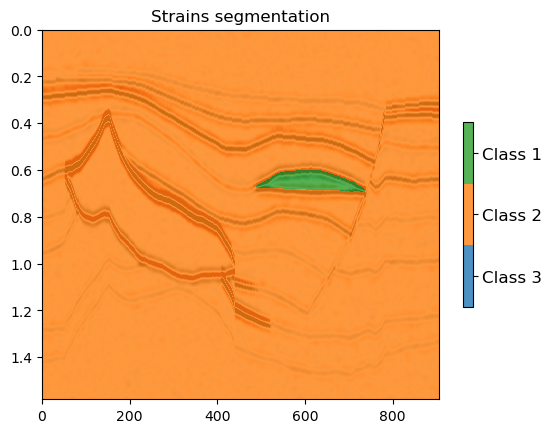

In [7]:
class_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
cmap = ListedColormap(class_colors)
bounds = [-1.5, -0.5, 0.5, 1.5]  # Boundaries for classes (-1, 0, 1)
norm = BoundaryNorm(bounds, len(class_colors))
# plt.figure(figsize=(8, 8))
plt.imshow(d2, cmap='RdGy',vmin=-0.1, vmax=0.1, extent=(0, dims[1], dims[0]*dt, 0))
im = plt.imshow(vcl.reshape(dims)-1, cmap=cmap, norm=norm, extent=(0, dims[1], dims[0]*dt, 0), alpha=0.8)
cbar = plt.colorbar(im, boundaries=bounds, ticks=[-1, 0, 1], shrink=0.5)
cbar.ax.set_yticklabels(['Class 3', 'Class 2', 'Class 1'], fontsize=12)
plt.title('Strains segmentation')
plt.axis('tight')
plt.show()